# Выбор локации для скважины

Допустим, вы работаете в добывающей компании «ГлавРосГосНефть». Нужно решить, где бурить новую скважину.

Вам предоставлены пробы нефти в трёх регионах: в каждом 10 000 месторождений, где измерили качество нефти и объём её запасов. Постройте модель машинного обучения, которая поможет определить регион, где добыча принесёт наибольшую прибыль. Проанализируйте возможную прибыль и риски техникой *Bootstrap.*

Шаги для выбора локации:

- В избранном регионе ищут месторождения, для каждого определяют значения признаков;
- Строят модель и оценивают объём запасов;
- Выбирают месторождения с самым высокими оценками значений. Количество месторождений зависит от бюджета компании и стоимости разработки одной скважины;
- Прибыль равна суммарной прибыли отобранных месторождений.

**Заказчик**: компания «ГлавРосГосНефть».

**Цель проекта**: определение региона, где добыча принесёт наибольшую прибыль.

Для достижения цели необходимо посредством машинного обучения обеспечить выполнение следующих задач:
1. Построить модель машинного обучения для определения региона, где добыча принесёт наибольшую прибыль.
2. Проанализировать возможную прибыль и риски техникой Bootstrap.

Условия задачи:
- Для обучения модели подходит только линейная регрессия (остальные — недостаточно предсказуемые).
- При разведке региона исследуют 500 точек, из которых с помощью машинного обучения выбирают 200 лучших для разработки.
- Бюджет на разработку скважин в регионе — 10 млрд рублей.
- При нынешних ценах один баррель сырья приносит 450 рублей дохода. Доход с каждой единицы продукта составляет 450 тыс. рублей, поскольку объём указан в тысячах баррелей.
- После оценки рисков нужно оставить лишь те регионы, в которых вероятность убытков меньше 2.5%. Среди них выбирают регион с наибольшей средней прибылью.

Данные синтетические: детали контрактов и характеристики месторождений не разглашаются.

In [1]:
# Установка библиотек для Практикума
!pip install scikit-learn==1.4.0 -q
!pip install matplotlib==3.5 -q

In [2]:
# Импорт библиотек, классов и функций
from typing import Union, Optional

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

from scipy.stats import shapiro
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import root_mean_squared_error
from scipy import stats as st

In [3]:
# Определение констант
RANDOM_STATE = 42
TEST_FRAC = .25 # Размер валидационной выборки

BUDGET = 10**10 # Бюджет на разработку скважин
INCOME = 45 * 10**4 # Доход с единицы продукта
LOSS_PROBA = .025 # Порог безубыточности

SAMPLES = 500 # Количество исследований на регион
COUNT = 200 # Количество скважин для разработки

BOOTSTRAP_RANGE = 1000

## Загрузка и подготовка данных

### Загрузка данных

In [4]:
regions = []
regions.append({
    "data": pd.read_csv("https://code.s3.yandex.net/datasets/geo_data_0.csv")
})
regions[0]["data"].info()
regions[0]["data"].sample(5, random_state=RANDOM_STATE)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


,id,f0,f1,f2,product
75721,7C6bA,0.599283,-0.557623,2.121187,122.073350
80184,dVxsn,0.739017,-0.463156,-1.347584,48.738540
19864,1Gm3l,1.422743,-0.534917,3.718798,131.338088
76699,Nzg1t,1.580244,-0.238458,2.805149,88.327757
92991,Z7b4F,0.918974,0.023961,2.598575,36.959266


Данные по региону 1 содержат 100'000 записей, пропуски отсутствуют.

In [5]:
regions.append({
    "data": pd.read_csv("https://code.s3.yandex.net/datasets/geo_data_1.csv")
})
regions[1]["data"].info()
regions[1]["data"].sample(5, random_state=RANDOM_STATE)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


,id,f0,f1,f2,product
75721,fYVDK,6.078076,0.084568,0.002957,0.000000
80184,3SQcq,16.462386,2.712946,1.993030,53.906522
19864,hQ1gJ,7.051898,0.766983,4.990194,134.766305
76699,Y4vux,-0.240045,-0.380804,3.999693,107.813044
92991,H1NUw,13.350111,-8.558281,0.002010,0.000000


Данные по региону 2 содержат 100'000 записей, пропуски отсутствуют.

In [6]:
regions.append({
    "data": pd.read_csv("https://code.s3.yandex.net/datasets/geo_data_2.csv")
})
regions[2]["data"].info()
regions[2]["data"].sample(5, random_state=RANDOM_STATE)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


,id,f0,f1,f2,product
75721,sPjbT,2.111118,-1.679773,3.112240,117.441301
80184,1u4uo,0.734759,0.747788,3.670879,47.841249
19864,kZ6HO,-2.513109,0.844631,-4.922889,45.883483
76699,gCZGK,-2.035301,-1.522988,5.072839,139.014608
92991,rqJHx,2.744145,1.429952,-1.372661,84.004276


Данные по региону 3 также содержат 100'000 записей, пропуски отсутствуют.

### Исследование данных

In [7]:
# Функция для вывода гистограмм
def show_hist(
    data: Union[pd.Series, pd.DataFrame], title: str, xlabel: str, 
    ylabel: str = "Количество", columns: Optional[str] = None, 
    bins: int = 50, figsize: tuple = (14, 6), alpha: float = 1, 
    stacked: bool = True, boxplot: bool = True
):
    if isinstance(data, pd.Series):
        data = data.rename(xlabel).to_frame()
    else:
        data = data.rename_axis(columns, axis=1)
    fig = plt.figure(figsize=figsize)
    if boxplot:
        gs = fig.add_gridspec(
            2, 1, height_ratios=[3, len(data.columns)]
        )
        ax0 = fig.add_subplot(gs[0,0])
        ax1 = fig.add_subplot(gs[1,0])
        data.boxplot(vert=False, ax=ax1)
        if (len(data.columns) == 1):
            yticks = ax1.get_yticks()
            ax1.set_yticks(yticks, labels=[""])
    else:
        ax0 = plt.gca()
    ax0.hist(data, bins=bins, alpha=alpha, 
             stacked=stacked)
    if data.shape[1] > 1:
        ax0.legend(data.columns)
    ax0.grid()
    ax0.set_ylabel(ylabel, size=16)
    plt.suptitle(title, size=18, color="C0")
    plt.xlabel(xlabel, size=16)
    plt.tight_layout()
    plt.show()
    desc = data.describe(
        [.0012, .01, .25, .5, .75, .99, .9988]
    ).T.drop(columns="count").style.format("{:,.2f}").background_gradient(
        cmap=sns.diverging_palette(250, 25, s=100, l=50, as_cmap=True), 
        axis=1
    )
    display(desc)
    
# Функция вывода диаграммы рассеяния
def show_scatter(data: pd.DataFrame, x: str, y: str, title: str,
                 ax=None, alpha: float = 0.05, size: int = 1, noise=(0, 0)):
    data = data.copy()
    # Добавление дрожания для диаграммы рассеяния
    data[x] = data[x] + np.random.normal(0, noise[0], size=len(data))
    data[y] = data[y] + np.random.normal(0, noise[1], size=len(data))
    
    ax = data.plot(kind="scatter", x=x, y=y, alpha=alpha, s=size, ax=ax)
    ax.set_title(title)
    return ax

#### Регион 1

In [8]:
print(
    "Количество явных дубликатов:",
    regions[0]["data"].duplicated().sum()
)
print(
    "Количество неявных дубликатов (без id скважины):",
    regions[0]["data"].duplicated(subset=["f0", "f1", "f2", "product"]).sum()
)
print(
    "Количество неявных дубликатов (без целевого признака):",
    regions[0]["data"].duplicated(subset=["f0", "f1", "f2"]).sum()
)
print(
    "Количество дубликатов id:",
    regions[0]["data"].duplicated(subset=["id"]).sum()
)

Количество явных дубликатов: 0
Количество неявных дубликатов (без id скважины): 0
Количество неявных дубликатов (без целевого признака): 0
Количество дубликатов id: 10


По региону 1 явные и неявные (без учета id и целевого признака) дубликаты отсутствуют. Однако имеются дубликаты id, что необходимо отметить, также id не может быть использовано при дальнейшей работе с данными.

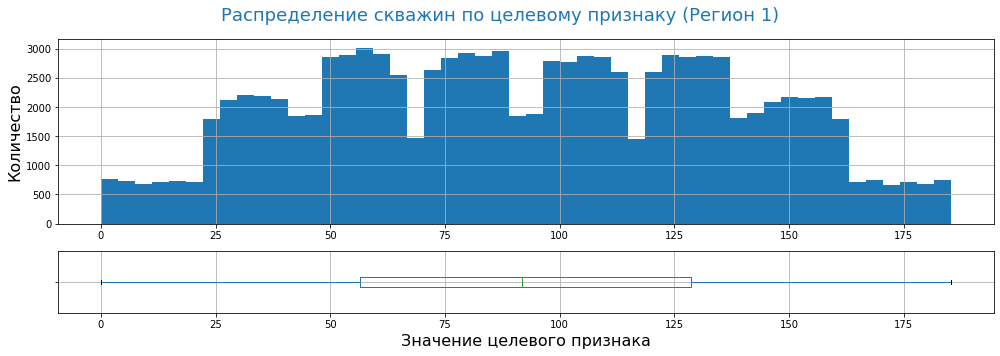

,mean,std,min,0.1%,1%,25%,50%,75%,99%,99.9%,max
Значение целевого признака,92.50,44.29,0.00,0.61,4.91,56.50,91.85,128.56,180.35,184.70,185.36


In [9]:
show_hist(
    regions[0]["data"]["product"],
    "Распределение скважин по целевому признаку (Регион 1)", "Значение целевого признака", 
    figsize=(14, 5), boxplot=True
)

Целевой пизнак имеет мультимодальное распределение, заметны 4 более высоких пика значений в центре графика, 2 пика по ниже с двух сторон, а также достаточно равномерное распределение крайних значений. 

Значения признака начинаются с 0, половина значений располагается в пределах 56.5 и 128.56, медиана 91.85, среднее 92.5, максимальное значение 185.36.

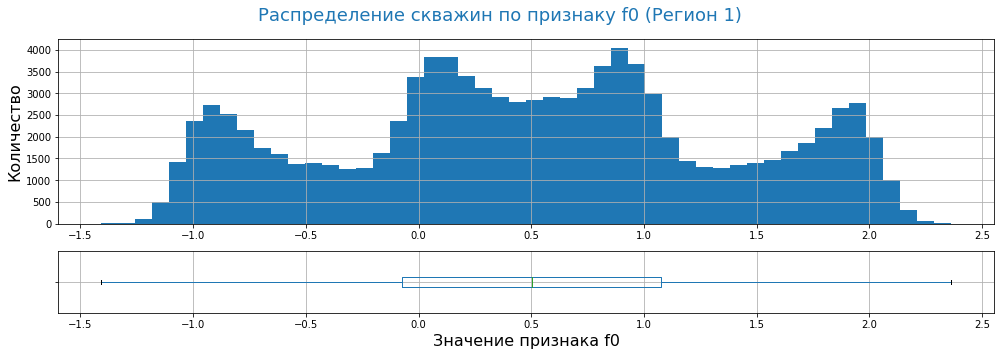

,mean,std,min,0.1%,1%,25%,50%,75%,99%,99.9%,max
Значение признака f0,0.50,0.87,-1.41,-1.18,-1.08,-0.07,0.50,1.07,2.08,2.19,2.36


In [10]:
show_hist(
    regions[0]["data"]["f0"],
    "Распределение скважин по признаку f0 (Регион 1)", "Значение признака f0", 
    figsize=(14, 5), boxplot=True
)

По признаку f0 распределение скважин также мультимодальное, заметны 2 более высоких пика по количеству ближе к центру графика, а также 2 пика по меньше ближе к крайним значениям. Переходы более сглаженные, чем у целевого признака.

Минимальное значение признака -1.41, половина значений располагается в пределах -0.07 и 1.07, среднее и медиана 0.5, максимальное значение 2.36.

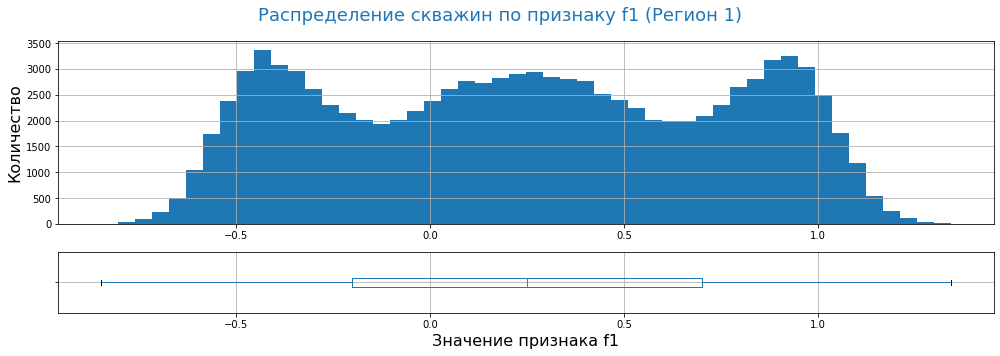

,mean,std,min,0.1%,1%,25%,50%,75%,99%,99.9%,max
Значение признака f1,0.25,0.50,-0.85,-0.72,-0.62,-0.20,0.25,0.70,1.12,1.22,1.34


In [11]:
show_hist(
    regions[0]["data"]["f1"],
    "Распределение скважин по признаку f1 (Регион 1)", "Значение признака f1", 
    figsize=(14, 5), boxplot=True
)

По признаку f1 также заметна мультимодальность, один пик количества скважин в центре имеет меньшую высоту, ближе к крайним значениям 2 более высоких пика.

Минимальное значение -0.85, медиана и мода равны 0.25, максимальное значение 0.7.

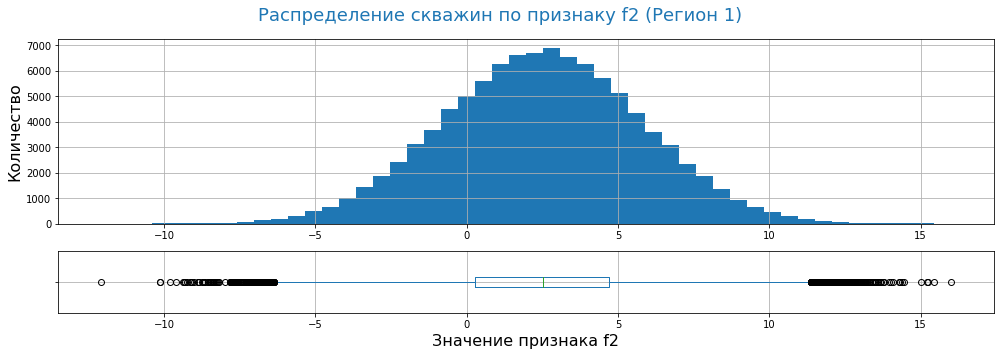

,mean,std,min,0.1%,1%,25%,50%,75%,99%,99.9%,max
Значение признака f2,2.50,3.25,-12.09,-6.97,-4.97,0.29,2.52,4.72,9.97,12.06,16.00


In [12]:
show_hist(
    regions[0]["data"]["f2"],
    "Распределение скважин по признаку f2 (Регион 1)", "Значение признака f2", 
    figsize=(14, 5), boxplot=True
)

График распределения признака f2 похож на колокол нормального распределения, и только по этому признаку имеется отклонение между средним значением и медианой, также только по этому признаку имеются выбросы.

Минимальное значение -12.09, среднее 2.50, медиана 2.52, максимальное 16.

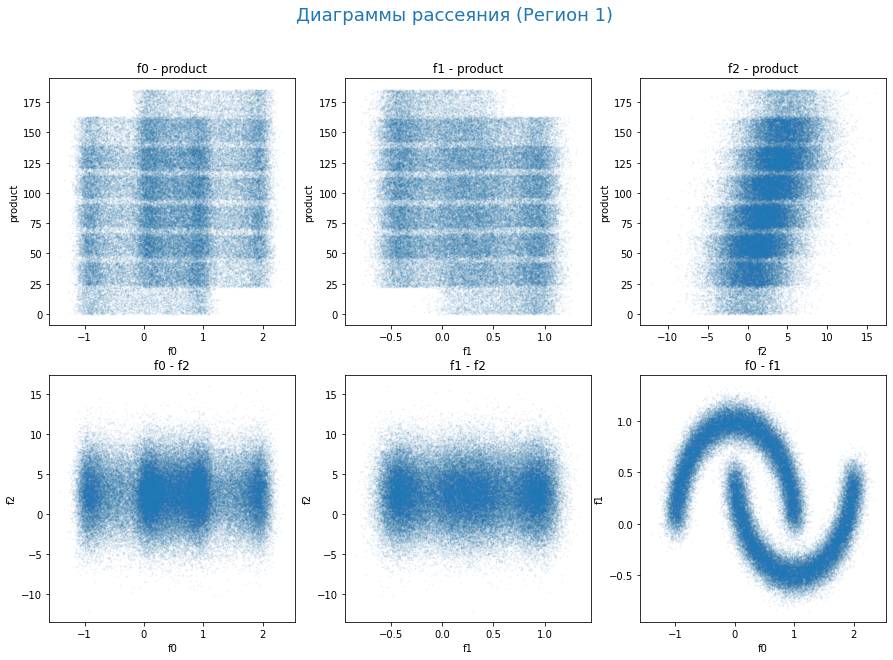

Таблица корреляции


,f0,f1,f2,product
f0,1.00,-0.47,-0.00,0.13
f1,-0.47,1.00,0.00,-0.18
f2,-0.00,0.00,1.00,0.49
product,0.13,-0.18,0.49,1.00


In [13]:
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
k = 0
for i in range(len(regions[0]["data"].columns)-1, 0, -1):
    for j in range(1, i):
        show_scatter(
            regions[0]["data"], regions[0]["data"].columns[j], regions[0]["data"].columns[i],
             regions[0]["data"].columns[j] + " - " + regions[0]["data"].columns[i], 
            ax=axes[k//3, k%3]
        )
        k += 1
plt.suptitle("Диаграммы рассеяния (Регион 1)", size=18, color="C0")
plt.show()

# Таблица корреляции
print("Таблица корреляции")
regions[0]["data"].corr("spearman").style.format("{:,.2f}").background_gradient(
    cmap=sns.diverging_palette(250, 25, s=100, l=50, as_cmap=True), axis=1
)

По региону 1 можно отметить следующее:
1. Целевой признак имеет 6 более выраженных и 2 менее выраженных группы значений, распределение не нормальное.
2. Признак f0 имеет слабую положительную корреляцию с целевым (0.13), можно заметить 2 кластера, которые накладываются друг на друга. Каждый кластер судя по всему имеют бимодальное распределение, при наложении которых получается более высокая бимодальность ближе к средним значениям и более низкая к крайним.
3. Признак f1 имеет слабую отрицательную корреляцию с целевым (-0.18), также можно заметить 2 кластера, которые имеют противоположное отклонение - большее количество скважин приходится на крайние значения (меньшие или большие). На пересечении кластеры накладываются друг на друга, что дает дополнительный рост количества в районе средних значений.
4. Признак f2 имеет умеренную положительную корреляцию (0.49).
5. Диаграммы рассеяния признаков f0 и f1 по отношению к признаку f2 показывают отсутствие корреляции. По диаграмме рассеяния между признаками f0 и f1 можно визуально определить кластеры, а также то, каким образом они накладываются на каждый признак формируя мультимодальность в их распределении.

#### Регион 2

In [14]:
print(
    "Количество явных дубликатов:",
    regions[1]["data"].duplicated().sum()
)
print(
    "Количество неявных дубликатов (без id скважины):",
    regions[1]["data"].duplicated(subset=["f0", "f1", "f2", "product"]).sum()
)
print(
    "Количество неявных дубликатов (без целевого признака):",
    regions[1]["data"].duplicated(subset=["f0", "f1", "f2"]).sum()
)
print(
    "Количество дубликатов id:",
    regions[1]["data"].duplicated(subset=["id"]).sum()
)

Количество явных дубликатов: 0
Количество неявных дубликатов (без id скважины): 0
Количество неявных дубликатов (без целевого признака): 0
Количество дубликатов id: 4


По региону 2 также имеются дубликаты по id.

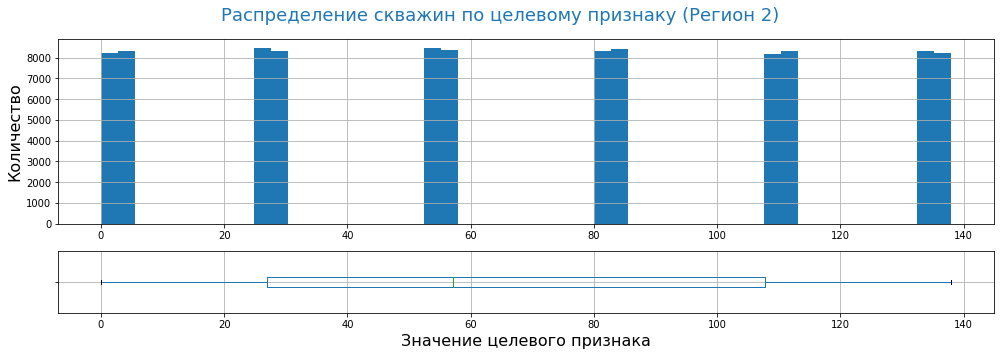

,mean,std,min,0.1%,1%,25%,50%,75%,99%,99.9%,max
Значение целевого признака,68.83,45.94,0.00,0.00,0.00,26.95,57.09,107.81,137.95,137.95,137.95


In [15]:
show_hist(
    regions[1]["data"]["product"],
    "Распределение скважин по целевому признаку (Регион 2)", "Значение целевого признака", 
    figsize=(14, 5), boxplot=True
)

Распределение целевого признака достаточно равномерно сгруппировано в 6 групп значений. Минимальное значение 0, среднее 68.83, медиана 57.09, максимальное 137.95.

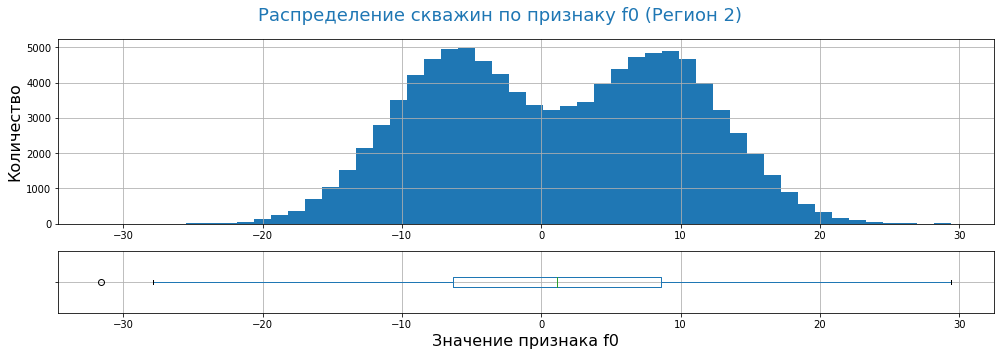

,mean,std,min,0.1%,1%,25%,50%,75%,99%,99.9%,max
Значение признака f0,1.14,8.97,-31.61,-20.33,-16.54,-6.30,1.15,8.62,18.86,22.87,29.42


In [16]:
show_hist(
    regions[1]["data"]["f0"],
    "Распределение скважин по признаку f0 (Регион 2)", "Значение признака f0", 
    figsize=(14, 5), boxplot=True
)

По признаку 1 наблюдается бимодальность. Минимальное значение -31.61 (выброс), среднее 1.14, медиана 1.15, максимальное 29.42.

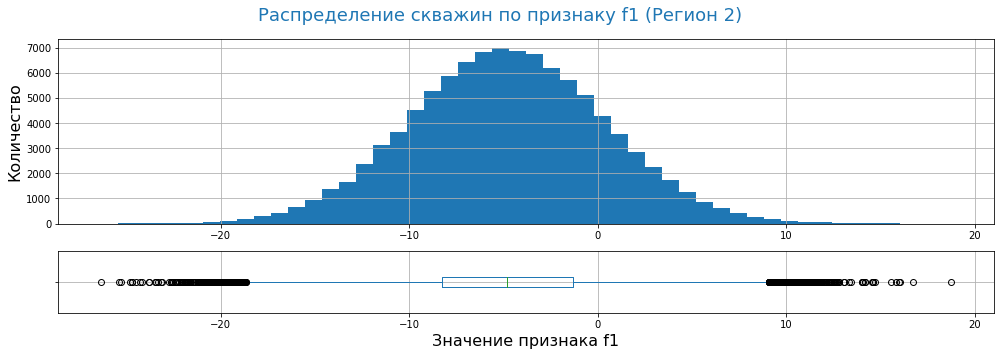

,mean,std,min,0.1%,1%,25%,50%,75%,99%,99.9%,max
Значение признака f1,-4.80,5.12,-26.36,-20.14,-16.58,-8.27,-4.81,-1.33,7.14,10.87,18.73


In [17]:
show_hist(
    regions[1]["data"]["f1"],
    "Распределение скважин по признаку f1 (Регион 2)", "Значение признака f1", 
    figsize=(14, 5), boxplot=True
)

График распределения признака f1 близкий к нормальному, имеются выбросы как в положительную так и в отрицательную сторону. Минимальное значение -26.36, среднее -4.80, медиана -4.81, максимальное 18.73.

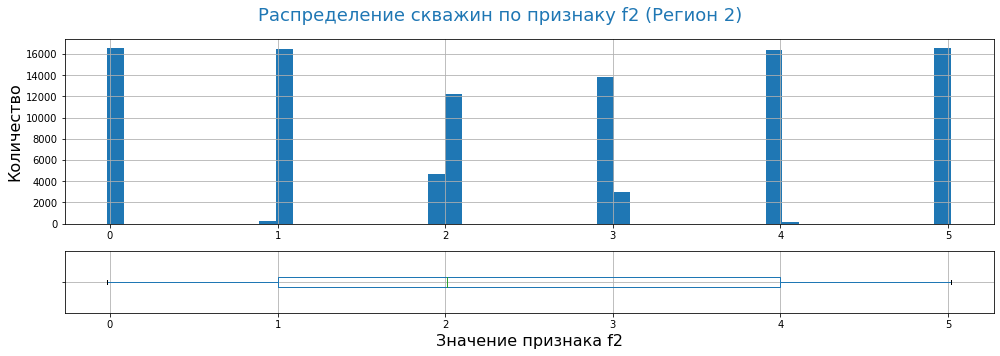

,mean,std,min,0.1%,1%,25%,50%,75%,99%,99.9%,max
Значение признака f2,2.49,1.70,-0.02,-0.01,-0.01,1.00,2.01,4.00,5.01,5.01,5.02


In [18]:
show_hist(
    regions[1]["data"]["f2"],
    "Распределение скважин по признаку f2 (Регион 2)", "Значение признака f2", 
    figsize=(14, 5), boxplot=True
)

Признак f2 также имеет 6 групп, которые расположились вблизи целых значений признака. Минимальное значение -0.02, среднее 2.49, медиана 2.01, максимальное значение 5.02.

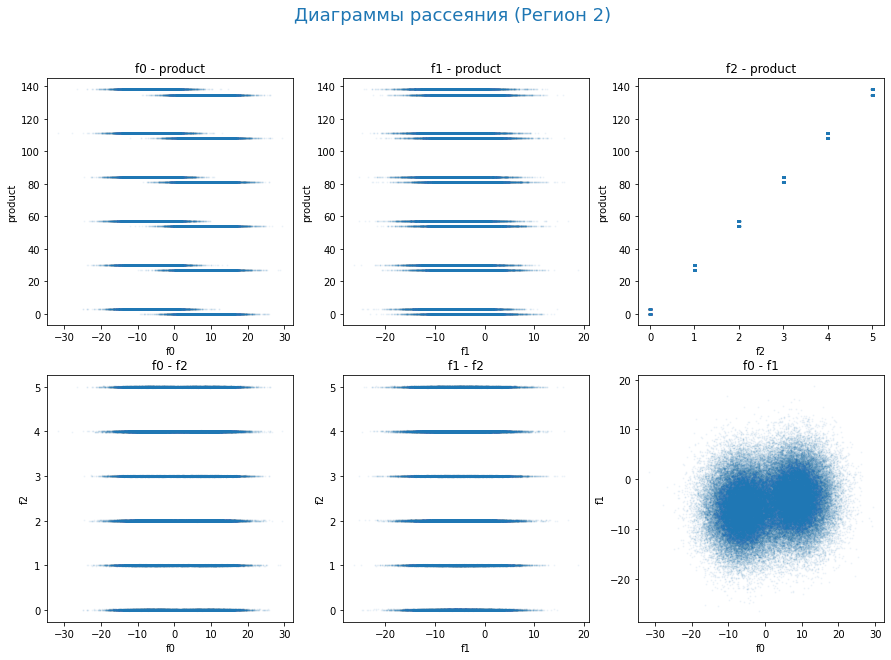

Таблица корреляции


,f0,f1,f2,product
f0,1.00,0.18,-0.00,-0.12
f1,0.18,1.00,-0.00,-0.03
f2,-0.00,-0.00,1.00,0.98
product,-0.12,-0.03,0.98,1.00


In [19]:
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
k = 0
for i in range(len(regions[1]["data"].columns)-1, 0, -1):
    for j in range(1, i):
        show_scatter(
            regions[1]["data"], regions[1]["data"].columns[j], regions[1]["data"].columns[i],
             regions[1]["data"].columns[j] + " - " + regions[1]["data"].columns[i], 
            ax=axes[k//3, k%3]
        )
        k += 1
plt.suptitle("Диаграммы рассеяния (Регион 2)", size=18, color="C0")
plt.show()

# Таблица корреляции
print("Таблица корреляции")
regions[1]["data"].corr("spearman").style.format("{:,.2f}").background_gradient(
    cmap=sns.diverging_palette(250, 25, s=100, l=50, as_cmap=True), axis=1
)

По региону 2 можно отметить следующее:
1. Целевой признак разбит на 6 ярко выраженных групп очень узких по разбросу значений.
2. Признак f0 имеет слабую отрицательную корреляцию (-0.12) с целевым, корреляция более выражена для двух подгрупп значений внутри каждой из 6 групп по целевому признаку - большее значение признака дает меньшее значение целевого. Распределение признака бимодальное.
3. Признак f1 имеет еще более слабую отрицательную корреляцию (-0,03) с целевым, корреляция аналогична признаку f0, только имеет гораздо меньшее расхождение между двумя подгруппами. Распределение признака похоже на нормальное.
4. По признаку f2 имеется очень высокая корреляция (0.98) с целевым признаком, имеется практически линейная зависимость. 
5. Корреляция между признаком f2 и признаками f0 и f1 отсутствует. По диаграмме рассеивания между признаками f0 и f1 можно заметить два кластера, которые больше разнесены по признаку f0 формируя бимодальность. Для признака f1 имеется слабый сдвиг между кластерами, вследствие чего распределение визуально похоже на нормальное.

#### Регион 3

In [20]:
print(
    "Количество явных дубликатов:",
    regions[2]["data"].duplicated().sum()
)
print(
    "Количество неявных дубликатов (без id скважины):",
    regions[2]["data"].duplicated(subset=["f0", "f1", "f2", "product"]).sum()
)
print(
    "Количество неявных дубликатов (без целевого признака):",
    regions[2]["data"].duplicated(subset=["f0", "f1", "f2"]).sum()
)
print(
    "Количество неявных дубликатов (без целевого признака):",
    regions[2]["data"].duplicated(subset=["id"]).sum()
)

Количество явных дубликатов: 0
Количество неявных дубликатов (без id скважины): 0
Количество неявных дубликатов (без целевого признака): 0
Количество неявных дубликатов (без целевого признака): 4


По региону 3 также имеются дубликаты по id.

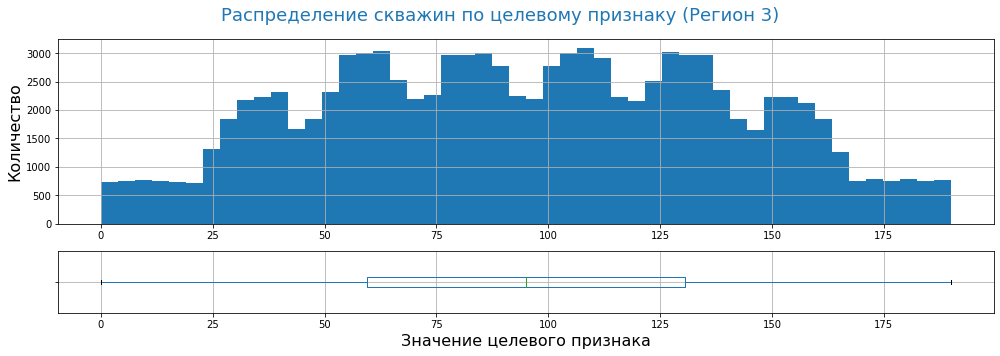

,mean,std,min,0.1%,1%,25%,50%,75%,99%,99.9%,max
Значение целевого признака,95.00,44.75,0.00,0.60,5.10,59.45,94.93,130.60,185.00,189.46,190.03


In [21]:
show_hist(
    regions[2]["data"]["product"],
    "Распределение скважин по целевому признаку (Регион 3)", "Значение целевого признака", 
    figsize=(14, 5), boxplot=True
)

Распределение скважин по целевому признаку очень похожа с

Значения признака также начинаются с 0, половина значений располагается в пределах 59.45 и 130.6, медиана 94.93, среднее 95, максимальное значение 190.03.

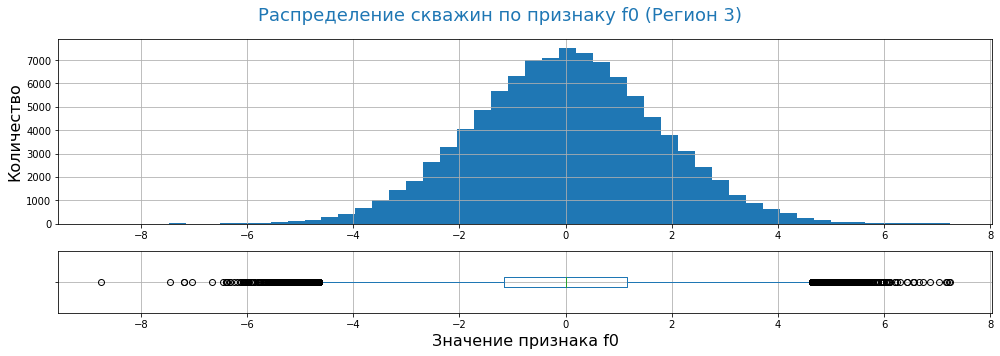

,mean,std,min,0.1%,1%,25%,50%,75%,99%,99.9%,max
Значение признака f0,0.00,1.73,-8.76,-5.24,-4.02,-1.16,0.01,1.16,4.06,5.28,7.24


In [22]:
show_hist(
    regions[2]["data"]["f0"],
    "Распределение скважин по признаку f0 (Регион 3)", "Значение признака f0", 
    figsize=(14, 5), boxplot=True
)

Распределение скважин по признаку f0 напоминает колокол нормального распределения. Минимальное значение -8.76, среднее 0, медиана близка к среднему 0.01, максимальное значение 7.24. В отрицательных значениях выброс сильнее.

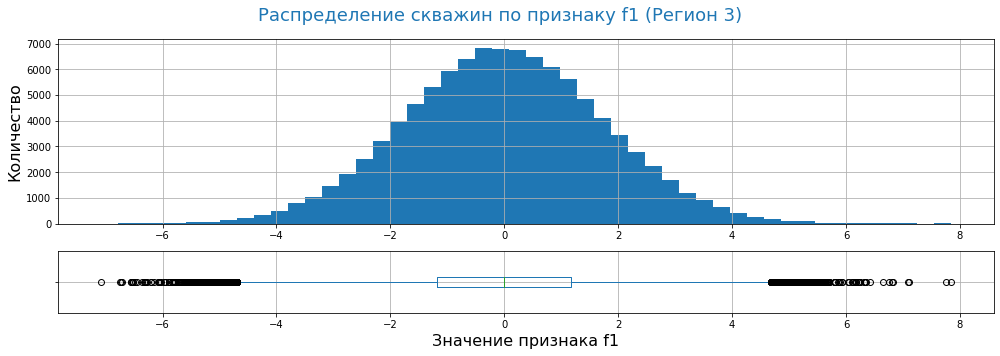

,mean,std,min,0.1%,1%,25%,50%,75%,99%,99.9%,max
Значение признака f1,-0.00,1.73,-7.08,-5.24,-4.00,-1.17,-0.01,1.16,4.02,5.27,7.84


In [23]:
show_hist(
    regions[2]["data"]["f1"],
    "Распределение скважин по признаку f1 (Регион 3)", "Значение признака f1", 
    figsize=(14, 5), boxplot=True
)

Распределение по признаку f1 также похоже на нормальное. Минимальное значение -7.08, среднее 0, медиана -0.01, максимальное значение 7.84. Небольшая асимметрия в сторону положительных значений.

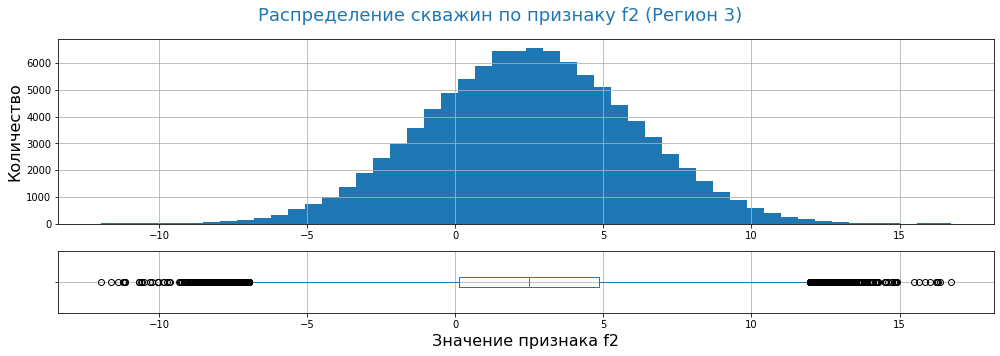

,mean,std,min,0.1%,1%,25%,50%,75%,99%,99.9%,max
Значение признака f2,2.50,3.47,-11.97,-7.77,-5.50,0.13,2.48,4.86,10.51,12.79,16.74


In [24]:
show_hist(
    regions[2]["data"]["f2"],
    "Распределение скважин по признаку f2 (Регион 3)", "Значение признака f2", 
    figsize=(14, 5), boxplot=True
)

Распределение скважин по признаку f2 также выглядит как нормальное. Минимальное значение -11.97, среднее 2.5, медиана 2.48, максимальное 16.74. График имеет небольшое смещение в положительную сторону, явно выраженная ассимметрия не наблюдается. 

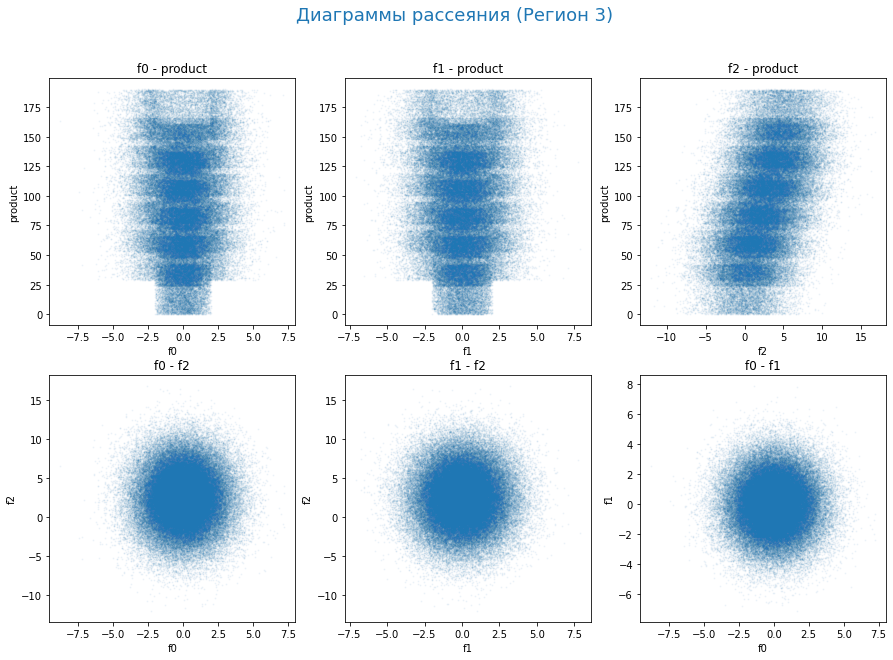

Таблица корреляции


,f0,f1,f2,product
f0,1.00,0.00,0.00,-0.00
f1,0.00,1.00,0.00,-0.00
f2,0.00,0.00,1.00,0.45
product,-0.00,-0.00,0.45,1.00


In [25]:
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
k = 0
for i in range(len(regions[2]["data"].columns)-1, 0, -1):
    for j in range(1, i):
        show_scatter(
            regions[2]["data"], regions[2]["data"].columns[j], regions[2]["data"].columns[i],
             regions[2]["data"].columns[j] + " - " + regions[2]["data"].columns[i], 
            ax=axes[k//3, k%3]
        )
        k += 1
plt.suptitle("Диаграммы рассеяния (Регион 3)", size=18, color="C0")
plt.show()

# Таблица корреляции
print("Таблица корреляции")
regions[2]["data"].corr("spearman").style.format("{:,.2f}").background_gradient(
    cmap=sns.diverging_palette(250, 25, s=100, l=50, as_cmap=True), axis=1
)

По региону 3 можно отметить следующее:
1. Распределение целевого признака очень похоже на распределение по региону 1.
2. Признак f0 не имеет корреляции с целевым. Распределение похоже на нормальное, однако по диаграмме рассеяния можно предположить также о наличии двух кластеров, сдвинутых относительно друг-друга по целевому признаку. Один из кластеров имеет более широкое распределение со сдвигом к более высоким значениям целевого признака, при этом в верхней части заметна бимодальность. Второй кластер имеет более узкое распределение с более высоким количеством скважин и имеет сдвиг к более низким значениям целевого признака.
3. Признак f1 также не имеет корреляции с целевым. Распределение также похоже на нормальное, диаграмма рассеяния имеет структуру, аналогичную признаку f0. 
4. По признаку f2 имеется умеренная корреляция (0.45) с целевым признаком, по мере увеличения среднего значения f2 происходит рост целевого признака, однако разброс достаточно высокий. Гистограмма распределения также похожа на нормальное.
5. Между признаками корреляция отсутствует, диаграммы рассеяния в целом напоминают нормальное распределение.

### Промежуточные выводы

Произведена загрузка данных геологоразведки трех регионов из файлов `geo_data_0.csv`, `geo_data_1.csv` и `geo_data_2.csv`:
1. В каждом файле по 100'000 записей.
2. Файлы содержат следующие признаки:
    - `id` — уникальный идентификатор скважины;
    - `f0`, `f1`, `f2` — три значимых признака точек;
    - `product` — объём запасов в скважине (тыс. баррелей).

Проведено исследование загруженых данных.

По всем регионам выявлены **дубликаты по id**. Необходимо выяснить причину появления дубликатов id. Значения по таким скважинам различаются, соответственно признак id не может быть использован при дальнейшей работе как индекс.

**По региону 1** можно отметить следующее:
- Целевой признак имеет 6 более выраженных и 2 менее выраженных группы значений, распределение не нормальное.
- Признак f0 имеет слабую положительную корреляцию с целевым (0.13), можно заметить 2 кластера, которые накладываются друг на друга. Каждый кластер судя по всему имеют бимодальное распределение, при наложении которых получается более высокая бимодальность ближе к средним значениям и более низкая к крайним.
- Признак f1 имеет слабую отрицательную корреляцию с целевым (-0.18), также можно заметить 2 кластера, которые имеют противоположное отклонение - большее количество скважин приходится на крайние значения (меньшие или большие). На пересечении кластеры накладываются друг на друга, что дает дополнительный рост количества в районе средних значений.
- Признак f2 имеет умеренную положительную корреляцию (0.49).
- Диаграммы рассеяния признаков f0 и f1 по отношению к признаку f2 показывают отсутствие корреляции. По диаграмме рассеяния между признаками f0 и f1 можно визуально определить кластеры, а также то каким образом они накладываются на каждый признак формируя мультимодальность в их распределении.

**По региону 2** можно отметить следующее:
- Целевой признак разбит на 6 ярко выраженных групп очень узких по разбросу значений.
- Признак f0 имеет слабую отрицательную корреляцию (-0.12) с целевым, корреляция более выражена для двух подгрупп значений внутри каждой из 6 групп по целевому признаку - большее значение признака дает меньшее значение целевого. Распределение признака бимодальное.
- Признак f1 имеет еще более слабую отрицательную корреляцию (-0,03) с целевым, корреляция аналогична признаку f0, только имеет гораздо меньшее расхождение между двумя подгруппами. Распределение признака похоже на нормальное.
- По признаку f2 имеется очень высокая корреляция (0.98) с целевым признаком, имеется практически линейная зависимость. 
- Корреляция между признаком f2 и признаками f0 и f1 отсутствует. По диаграмме рассеивания между признаками f0 и f1 можно заметить два кластера, которые больше разнесены по признаку f0 формируя бимодальность. Для признака f1 имеется слабый сдвиг между кластерами, вследствие чего распределение визуально похоже на нормальное.

**По региону 3** можно отметить следующее:
- Распределение целевого признака имеет аналогичную структуру, которая была по региону 1.
- Признак f0 не имеет корреляции с целевым. Распределение похоже на нормальное, однако по диаграмме рассеяния можно предположить также о наличии двух кластеров, сдвинутых относительно друг-друга по целевому признаку. Один из кластеров имеет более широкое распределение со сдвигом к более высоким значениям целевого признака, при этом в верхней части заметна бимодальность. Второй кластер имеет более узкое распределение с более высоким количеством скважин и имеет сдвиг к более низким значениям целевого признака.
- Признак f1 также не имеет корреляции с целевым. Распределение также похоже на нормальное, диаграмма рассеяния имеет структуру, аналогичную признаку f0. 
- По признаку f2 имеется умеренная корреляция (0.45) с целевым признаком, по мере увеличения среднего значения f2 происходит рост целевого признака, однако разброс достаточно высокий. Гистограмма распределения также похожа на нормальное.
- Между признаками корреляция отсутствует, диаграммы рассеяния в целом напоминают нормальное распределение.

Возможно для регионов 1 и 3 модель линейной регрессии будет не лучшим выбором, так как имееется недостаточно высокая корреляция между целевым и остальными признаками.

## Обучение и проверка модели

Произведем разделение данных на обучающую и валидационную выборки в соотношении 75:25.

In [26]:
for region in regions:
    region["train"], region["valid"] = train_test_split(
        region["data"].drop("id", axis=1), test_size=TEST_FRAC,
        random_state=RANDOM_STATE
    )
    print(f"Размер тренировочной выборки (Регион {i+1}):",  region["train"].shape)
    print(f"Размер тестовой выборки (Регион {i+1}):", region["valid"].shape, "\n")

Размер тренировочной выборки (Регион 2): (75000, 4)
Размер тестовой выборки (Регион 2): (25000, 4) 

Размер тренировочной выборки (Регион 2): (75000, 4)
Размер тестовой выборки (Регион 2): (25000, 4) 

Размер тренировочной выборки (Регион 2): (75000, 4)
Размер тестовой выборки (Регион 2): (25000, 4) 



Обучим модель и получим предсказания на валидационной выборке.

In [27]:
# Попробовал подобрать модель с помощью пайплайнов путем перебора скейлеров,
# оказалось что результат одинаковый независимо от скейлеров и без него, 
# соответственно не стал использовать пайплайн.

for i, region in enumerate(regions, 1):
    # Создание модели для региона
    region["model"] = LinearRegression(n_jobs=-1)
    # Обучение модели для региона
    region["model"].fit(
        region["train"].drop("product", axis=1), 
        region["train"]["product"]
    )
    # Сохранение предсказаний в валидационной выборке
    region["valid"]["predict"] = region["model"].predict(
        region["valid"].drop("product", axis=1)
    )
    print(f"\nРегион {i}:")
    display(
        region["valid"][["product", "predict"]].sample(
            15, random_state=RANDOM_STATE
        ).T.style.format("{:,.2f}").background_gradient(
            cmap=sns.diverging_palette(250, 25, s=100, l=50, as_cmap=True), 
            axis=1
        )
    )


Регион 1:


,46521,76473,74786,70598,27587,69582,67242,51811,11096,25620,75428,73111,31698,95362,12200
product,99.46,63.02,59.57,73.62,62.42,56.29,74.30,151.82,129.21,25.82,86.22,127.49,64.05,89.26,75.74
predict,85.97,71.59,56.84,68.53,92.53,94.87,102.52,105.22,101.82,75.84,75.48,123.63,85.60,115.26,92.99



Регион 2:


,46521,76473,74786,70598,27587,69582,67242,51811,11096,25620,75428,73111,31698,95362,12200
product,53.91,0.00,80.86,0.00,0.00,3.18,30.13,26.95,134.77,53.91,84.04,84.04,26.95,0.00,110.99
predict,53.97,0.46,81.94,0.36,-0.92,3.64,30.05,27.78,134.86,55.37,83.55,83.30,26.38,1.33,111.21



Регион 3:


,46521,76473,74786,70598,27587,69582,67242,51811,11096,25620,75428,73111,31698,95362,12200
product,44.52,126.35,112.39,104.09,53.74,141.10,44.42,136.74,99.03,126.85,56.17,130.75,30.27,87.25,106.30
predict,76.94,99.93,92.99,100.50,57.37,148.48,75.35,100.11,90.73,103.95,58.37,86.57,79.66,59.61,76.05


Произведено предсказание целевого признака на валидационной выборке, результаты предсказаний добавлены в валидационную выборку - столбец `predict`. 

По регионам 1 и 3 заметны достаточно большие отклонения между реальными и предсказанными значениями. Оценим показатели предсказанных моделью значений с фактическими, а также метрику RMSE.

In [28]:
for i, region in enumerate(regions, 1):
    print(f"\n Регион {i}:")
    print(
        "Средний запас сырья (фактический):",
        region["valid"]["product"].mean().round(2)
    )
    print(
        "Средний запас сырья (предсказанный):",
        region["valid"]["predict"].mean().round(2)
    )
    print(
        "RMSE модели:",
        root_mean_squared_error(
            region["valid"]["product"], region["valid"]["predict"]
        ).round(2)
    )


 Регион 1:
Средний запас сырья (фактический): 92.33
Средний запас сырья (предсказанный): 92.4
RMSE модели: 37.76

 Регион 2:
Средний запас сырья (фактический): 68.73
Средний запас сырья (предсказанный): 68.71
RMSE модели: 0.89

 Регион 3:
Средний запас сырья (фактический): 95.15
Средний запас сырья (предсказанный): 94.77
RMSE модели: 40.15


Несмотря на достаточно близкие средние значений фактического и предсказанного запаса сырья по всей выборке, по регионам 1 и 3 заметны очень большие средние отклонения - 37.76 и 40.15 соответственно.

### Промежуточные выводы

Исходные выбороки разделены на тренировочную и валидационную в соотношении 75:25.

Проведено обучение моделей для всех регионов, по результатам предсказаний моделями целевого признака можно ометить следующее:
1. По региону 1, при среднем запасе сырья в скважинах на уровне 92, средняя ошибка модели составляет 37.76. Это говорит о довольно плохих характеристиках обученной модели, вероятнее всего в виду низкой корреляции между целевым и другими признаками.
2. По региону 2, при среднем запасе сырья в скважинах на уровне 68.7, метрика RMSE показывает хорошие значения - 0.89.
3. По региону 3, при среднем запасе сырья в скважинах на уровне 95, метрика RMSE также высокая - 40.15. Для данной выборки также характерна низкая корреляция между целевым и остальными признаками.


## Подготовка к расчёту прибыли

Оценим входные данные для рассчета прибыли:

In [29]:
# Константы прописал в начале проекта
print(f"Бюджет на разработку скважин в регионе: {BUDGET:,.2f} рублей.")
print(f"Доход с каждой тысячи баррелей продукта: {INCOME:,.2f} рублей.")
print(f"Вероятность убытков не более: {LOSS_PROBA:.2%}")
print(f"Количество исследований на регион: {SAMPLES}")
print(f"Количество скважин для разработки: {COUNT}\n")

Бюджет на разработку скважин в регионе: 10,000,000,000.00 рублей.
Доход с каждой тысячи баррелей продукта: 450,000.00 рублей.
Вероятность убытков не более: 2.50%
Количество исследований на регион: 500
Количество скважин для разработки: 200



Оценим средний объем сырья для безубыточной разработки скважин в регионе:

In [30]:
print(
    "Средний объем для безубыточной разработки региона:",
    round(BUDGET / COUNT / INCOME, 3), "тыс. баррелей."
)
for i, region in enumerate(regions, 1):
    print(
        f"Средний запас сырья (Регион {i}): ", region["valid"]["product"].mean().round(3), 
        " тыс. баррелей, что отличается на ",
        (100 - 100 * region["valid"]['product'].mean() / (BUDGET / COUNT / INCOME)).round(2),
        "%", sep=""
    )

Средний объем для безубыточной разработки региона: 111.111 тыс. баррелей.
Средний запас сырья (Регион 1): 92.326 тыс. баррелей, что отличается на 16.91%
Средний запас сырья (Регион 2): 68.725 тыс. баррелей, что отличается на 38.15%
Средний запас сырья (Регион 3): 95.151 тыс. баррелей, что отличается на 14.36%


In [31]:
# Функция для расчета прибыли
def profit_calc(
    d: pd.DataFrame, target_column: str, predict_column: str, 
    n=COUNT, income=INCOME, budget=BUDGET, ascending=False
):
    return d.sort_values(
        by=predict_column, ascending=ascending
    ).head(n)[target_column].sum() * income - budget

### Промежуточные выводы

Средний объем для безубыточной разработки скважин в регионе составляет 111.111 тыс. баррелей, средние значения запаса сырья по регионам отличаются от объема безубыточной разработки:
- по региону 1 средний запас на 16.91% ниже среднего уровня безубыточной разработки;
- по региону 2 средний запас на 38.15% ниже среднего уровня безубыточной разработки;
- по региону 3 средний запас на 14.36% ниже среднего уровня безубыточной разработки;

Подготовлена функция для рассчета прибыли по формуле: Σ(фактический объем из топ 200 по предсказанию) * (доход с барреля) - бюджет.

## Расчёт прибыли и рисков 

Исходя из поставленной задачи, средний объем запасов в 200 скважинах, для которых модель предсказала наиболее высококие значения запасов из любых 500 скважин региона, должен быть не ниже объема для безубыточной разработки скважин, не менее чем в 97.5% случаев. Для поиска распределения прибыли применим технику Bootstrap с 1000 выборок.

In [32]:
def region_result_info(d):
    print(f"Среднняя прибыль: {d['mean_profit']:,.2f}")
    print(f"Доверительный интервал ({(1 - 2 * LOSS_PROBA):.0%}):",
          f" минимум {d['confidence_interval'][0]:,.2f} рублей,",
          f"максимум {d['confidence_interval'][1]:,.2f} рублей")
    print(f"Вероятность убытков: {d['loss_proba']:.2%}")

state = np.random.RandomState(RANDOM_STATE)

# Bootstrap по всем регионам
for i, region in enumerate(regions, 1):
    values = []
    # Bootstrap по региону i
    for j in range(BOOTSTRAP_RANGE):
        values.append(
            profit_calc(
                region["valid"][["product", "predict"]].sample(
                    500, replace=True, random_state=state
                ), 
                "product", "predict"
            )
        )
    region["result"] = {
        "mean_profit": np.mean(values),
        "confidence_interval": np.quantile(values, [.025, .975]),
        "loss_proba": (np.array(values) < 0).mean()
    }
    # Вывод результатов по региону
    print(f"Регион {i}:")
    region_result_info(region["result"])
    print()
    
# Поиск лучшего региона
best_region = None
for i, region in enumerate(regions):
    if (region["result"]["loss_proba"] < 
        region["result"]["confidence_interval"][0]):
        if ((best_region is None) or 
            (region["result"]["confidence_interval"][0] > 
            regions[best_region]["result"]["confidence_interval"][0])):
            best_region = i

if not (best_region is None):
    print(f"Лучший регион - Регион {best_region + 1}")
    region_result_info(regions[best_region]["result"])
else:
    print("Нет региона, подходящего под условия задачи.")

Регион 1:
Среднняя прибыль: 399,575,478.05
Доверительный интервал (95%):  минимум -110,467,895.33 рублей, максимум 897,460,327.72 рублей
Вероятность убытков: 6.00%

Регион 2:
Среднняя прибыль: 452,576,594.29
Доверительный интервал (95%):  минимум 52,309,409.80 рублей, максимум 830,146,313.26 рублей
Вероятность убытков: 0.90%

Регион 3:
Среднняя прибыль: 378,705,903.66
Доверительный интервал (95%):  минимум -127,779,434.99 рублей, максимум 907,923,483.22 рублей
Вероятность убытков: 7.50%

Лучший регион - Регион 2
Среднняя прибыль: 452,576,594.29
Доверительный интервал (95%):  минимум 52,309,409.80 рублей, максимум 830,146,313.26 рублей
Вероятность убытков: 0.90%


### Промежуточные итоги

По результатам применения техники Bootstrap с 1000 выборками для валидационного датасета можно выделить следующее:
1. По региону 1 средняя прибыль составила 399.6 миллионов рублей, при этом вероятность убытков составила 6%, что превышает порог в 2.5%. Данный регион исключается из рассматриваемых.
2. По региону 2 средняя прибыль составила 452.6 миллиона рублей, вероятность убытков составила 0.9%, данный регион соответтсвует всем критериям задачи.
3. По региону 3 средняя прибыль составила 378.7 миллиона рублей, однако вероятность убытков составила 7.5%, что также превышает установленный порог. Данный регион также исключается из рассматриваемых.

Наиболее подходящим регионом по результатам проекта является **Регион 2**, так как предсказанные значения модели линейной регрессии имеют достаточную точность, а результаты анализа применимости модели техникой Bootstrap только для этого региона продемонстрировали результаты, которые удовлетворяют поставленной задаче - средняя прибыль по результатам исследования на 1000 выборках (полученных методом Монте-Карло) составила 452.6 миллиона рублей, что является наибольшим значением среди регионов, а также вероятность убытков составила 0.9%, что соответству требованиям задачи - менее 2.5%.

## Чек-лист готовности проекта

Поставьте 'x' в выполненных пунктах. Далее нажмите Shift+Enter.

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке исполнения
- [x]  Выполнен шаг 1: данные подготовлены
- [x]  Выполнен шаг 2: модели обучены и проверены
    - [x]  Данные корректно разбиты на обучающую и валидационную выборки
    - [x]  Модели обучены, предсказания сделаны
    - [x]  Предсказания и правильные ответы на валидационной выборке сохранены
    - [x]  На экране напечатаны результаты
    - [x]  Сделаны выводы
- [x]  Выполнен шаг 3: проведена подготовка к расчёту прибыли
    - [x]  Для всех ключевых значений созданы константы Python
    - [x]  Посчитано минимальное среднее количество продукта в месторождениях региона, достаточное для разработки
    - [x]  По предыдущему пункту сделаны выводы
    - [x]  Написана функция расчёта прибыли
- [x]  Выполнен шаг 4: посчитаны риски и прибыль
    - [x]  Проведена процедура *Bootstrap*
    - [x]  Все параметры бутстрепа соответствуют условию
    - [x]  Найдены все нужные величины
    - [x]  Предложен регион для разработки месторождения
    - [x]  Выбор региона обоснован

## Итоговые выводы

Произведена загрузка данных геологоразведки трех регионов из файлов `geo_data_0.csv`, `geo_data_1.csv` и `geo_data_2.csv`:
1. В каждом файле по 100'000 записей.
2. Файлы содержат следующие признаки:
    - `id` — уникальный идентификатор скважины;
    - `f0`, `f1`, `f2` — три значимых признака точек;
    - `product` — объём запасов в скважине (тыс. баррелей).

Проведено исследование загруженых данных. По всем регионам выявлены **дубликаты по id**. Необходимо выяснить причину появления дубликатов id. Значения по таким скважинам различаются, соответственно признак id не может быть использован при дальнейшей работе как индекс.

**По региону 1** можно отметить следующее:
- Целевой признак имеет 6 более выраженных и 2 менее выраженных группы значений, распределение не нормальное.
- Признак f0 имеет слабую положительную корреляцию с целевым (0.13), можно заметить 2 кластера, которые накладываются друг на друга. Каждый кластер судя по всему имеют бимодальное распределение, при наложении которых получается более высокая бимодальность ближе к средним значениям и более низкая к крайним.
- Признак f1 имеет слабую отрицательную корреляцию с целевым (-0.18), также можно заметить 2 кластера, которые имеют противоположное отклонение - большее количество скважин приходится на крайние значения (меньшие или большие). На пересечении кластеры накладываются друг на друга, что дает дополнительный рост количества в районе средних значений.
- Признак f2 имеет умеренную положительную корреляцию (0.49).
- Диаграммы рассеяния признаков f0 и f1 по отношению к признаку f2 показывают отсутствие корреляции. По диаграмме рассеяния между признаками f0 и f1 можно визуально определить кластеры, а также то каким образом они накладываются на каждый признак формируя мультимодальность в их распределении.

**По региону 2** можно отметить следующее:
- Целевой признак разбит на 6 ярко выраженных групп очень узких по разбросу значений.
- Признак f0 имеет слабую отрицательную корреляцию (-0.12) с целевым, корреляция более выражена для двух подгрупп значений внутри каждой из 6 групп по целевому признаку - большее значение признака дает меньшее значение целевого. Распределение признака бимодальное.
- Признак f1 имеет еще более слабую отрицательную корреляцию (-0,03) с целевым, корреляция аналогична признаку f0, только имеет гораздо меньшее расхождение между двумя подгруппами. Распределение признака похоже на нормальное.
- По признаку f2 имеется очень высокая корреляция (0.98) с целевым признаком, имеется практически линейная зависимость. 
- Корреляция между признаком f2 и признаками f0 и f1 отсутствует. По диаграмме рассеивания между признаками f0 и f1 можно заметить два кластера, которые больше разнесены по признаку f0 формируя бимодальность. Для признака f1 имеется слабый сдвиг между кластерами, вследствие чего распределение визуально похоже на нормальное.

**По региону 3** можно отметить следующее:
- Распределение целевого признака имеет аналогичную структуру, которая была по региону 1.
- Признак f0 не имеет корреляции с целевым. Распределение похоже на нормальное, однако по диаграмме рассеяния можно предположить также о наличии двух кластеров, сдвинутых относительно друг-друга по целевому признаку. Один из кластеров имеет более широкое распределение со сдвигом к более высоким значениям целевого признака, при этом в верхней части заметна бимодальность. Второй кластер имеет более узкое распределение с более высоким количеством скважин и имеет сдвиг к более низким значениям целевого признака.
- Признак f1 также не имеет корреляции с целевым. Распределение также похоже на нормальное, диаграмма рассеяния имеет структуру, аналогичную признаку f0. 
- По признаку f2 имеется умеренная корреляция (0.45) с целевым признаком, по мере увеличения среднего значения f2 происходит рост целевого признака, однако разброс достаточно высокий. Гистограмма распределения также похожа на нормальное.
- Между признаками корреляция отсутствует, диаграммы рассеяния в целом напоминают нормальное распределение.

Выдвинута гипотеза, что для регионов 1 и 3 модель линейной регрессии будет не лучшим выбором, так как корреляция между целевым и остальными признаками недостаточно высокая.

Исходные выбороки разделены на тренировочную и валидационную в соотношении 75:25.

Проведено обучение моделей для всех регионов, по результатам предсказаний моделями целевого признака можно ометить следующее:
1. По региону 1, при среднем запасе сырья в скважинах на уровне 92, средняя ошибка модели составляет 37.76. Это говорит о довольно плохих характеристиках обученной модели, вероятнее всего в виду низкой корреляции между целевым и другими признаками.
2. По региону 2, при среднем запасе сырья в скважинах на уровне 68.7, метрика RMSE показывает хорошие значения - 0.89.
3. По региону 3, при среднем запасе сырья в скважинах на уровне 95, метрика RMSE также высокая - 40.15. Для данной выборки также характерна низкая корреляция между целевым и остальными признаками.

Проведена оценка поставленной задачи и параметров валидационной выборки. Средний объем для безубыточной разработки скважин в регионе составляет 111.111 тыс. баррелей, средние значения запаса сырья по регионам отличаются от объема безубыточной разработки:
- по региону 1 средний запас на 16.91% ниже среднего уровня безубыточной разработки;
- по региону 2 средний запас на 38.15% ниже среднего уровня безубыточной разработки;
- по региону 3 средний запас на 14.36% ниже среднего уровня безубыточной разработки;

Подготовлена функция для рассчета прибыли по формуле: Σ(фактический объем из топ 200 по предсказанию) * (доход с барреля) - (бюджет на разработку скважин).

По результатам применения техники Bootstrap с 1000 выборками для валидационного датасета можно выделить следующее:
1. По региону 1 средняя прибыль составила 399.6 миллионов рублей, при этом вероятность убытков составила 6%, что превышает порог в 2.5%. Данный регион исключается из рассматриваемых.
2. По региону 2 средняя прибыль составила 452.6 миллиона рублей, вероятность убытков составила 0.9%, данный регион соответтсвует всем критериям задачи.
3. По региону 3 средняя прибыль составила 378.7 миллиона рублей, однако вероятность убытков составила 7.5%, что также превышает установленный порог. Данный регион также исключается из рассматриваемых.

Наиболее подходящим регионом по результатам проекта является **Регион 2**, так как предсказанные значения модели линейной регрессии имеют достаточную точность, а результаты анализа применимости модели техникой Bootstrap только для этого региона продемонстрировали результаты, которые удовлетворяют поставленной задаче:
- средняя прибыль по результатам исследования на 1000 выборках составила 452.6 миллиона рублей, что является самым высоким значением среди всех регионов;
- вероятность убытков составила 0.9%, что соответству требованиям задачи - менее 2.5%.